<table><tr>
<td> 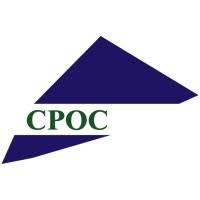 </td>
<td> <img src="https://ars.els-cdn.com/content/image/1-s2.0-B9780444635334000068-f06-15-9780444635334.jpg" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

<h1 align=center><font size = 4> Munish Kumar </font></h1>
<h1 align=center><font size = 4> P5628_MTJA_CCS_Feasibility </font></h1>
<h1 align=center><font size = 4> Special Core Analysis </font></h1>
<h1 align=center><font size = 3> ERCE 2022 </font></h1>

#### Libraries

In [1]:
# Only install the following libraries if you dont have it, otherwise leave it commented out

#!conda install -c anaconda natsort --yes
#!conda install -c anaconda xlrd --yes
#!pip install sympy --user

# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
from natsort import natsorted
sns.set()

# Sklearn Liraries
from sklearn import preprocessing

# For Latex style text
from sympy import S, symbols, printing

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

# Display max rows
pd.set_option('display.max_rows', 500)

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


###### Declare some global variables

In [2]:
dir_name = r'C:\Users\mkumar\Documents\GitHub\munishkumar-gh.github.io\Core_Analysis_CPOC'
filename_suffix = 'csv'

# Font, marker size and axis rotation
edgecolors = 'black'
markersize = 16
alpha = 0.5
size = 18
rotation = 0

###### Series of Functions

In [3]:
# Function to look at first 5 and last 5 elements in a dataframe
def ends(df, x=5):
    return df.head(x).append(df.tail(x))
setattr(pd.DataFrame,'ends',ends)

In [4]:
# Function to read out file
def file_out(df, dir_name, base_filename, filename_suffix):
    try:
        csvs_sht = os.path.join(dir_name, base_filename + "." + filename_suffix)
        df.to_csv(csvs_sht, index = False, header=True)
        print ("Final File Extract Produced")
    except IOError:
        print("I/O error")
    return

In [5]:
# Function to search for a text string
def search_words(text):
    result = re.findall(r'\b[^\d\W]+\b', text)
    return " ".join(result)

In [6]:
# Function to plot grain density
def plot_grain_density(mod_df, title, bins, xmin, xmax, savefn):
    sns.set()
    sns.set_style("whitegrid")     
    sns.set_style("ticks", 
                  {"xtick.major.size":size,
                  "ytick.major.size":size}
                 )
    sns.axes_style("whitegrid")
    kwargs = {'cumulative': True}

    ax = sns.distplot(mod_df, 
                      bins = bins, 
                      kde=False, 
                      norm_hist=False, 
                      color = 'r',
                      #bw_adjust=.25,
                      #hist_kws=kwargs, 
                      #kde_kws=kwargs
                     )

    ax.set(ylabel='Frequency', 
           #xlabel='common ylabel',
           xlim = (xmin, xmax),
          )

    ax.legend(labels=['Histogram', 'Frequency'])
    plt.title(title)
    plt.grid(True)

    plt.savefig(savefn, transparent=True)
    return

In [7]:
# Plotting the effect of NOBP
def plot_NOBP(mod_df, df_sub, grouped, color, savefn):
    # Plot per group
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(121)

    for i, (name, group) in enumerate(grouped):
        sc = ax.scatter(
            group["NOB (psi)"],
            group["Porosity (%)"],
            s = markersize**2,
            alpha=0.5,
            label=name,
            edgecolors = edgecolors,
        )  

    # Add legends (one for gender, other for size)
    ax.add_artist(ax.legend(title='Well Name'))
    ax.legend(*sc.legend_elements("colors", num=6))
    ax.set_xlabel('Net Overburden Pressure (psi)', fontsize=size)
    ax.set_ylabel('Porosity (%)', fontsize=size)

    plt.xticks(rotation = rotation, fontsize=size)
    plt.yticks(rotation = rotation, fontsize=size)
    plt.ylim(0,20) 
    plt.grid(True)
    
    ax1 = fig.add_subplot(122)

    for i, (name, group) in enumerate(grouped):
        sc1 = ax1.scatter(
            group["NOB (psi)"],
            group["K_klin (mD)"],
            s = markersize**2,
            alpha=0.5,
            label=name,
            edgecolors = edgecolors,
        )  

    # Add legends 
    ax1.add_artist(ax1.legend(title='Well Name'))
    ax1.legend(*sc1.legend_elements("colors", num=6))
    ax1.set_xlabel('Net Overburden Pressure (psi)', fontsize=size)
    ax1.set_ylabel('Permeability (mD)', fontsize=size)

    plt.xticks(rotation = rotation, fontsize=size)
    plt.yticks(rotation = rotation, fontsize=size)
    #plt.ylim(0,20)

    plt.tight_layout()
    plt.grid(True)

    plt.savefig(savefn, transparent=True)
    return

In [8]:
def plot_PP(df_sub, grouped, color, title, savefn, xint1, yint1, xint2, yint2, xlimit, ylimit, plot_line_eqn):
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(111)

    for i, (name, group) in enumerate(grouped):
        sc = ax.scatter(
            group["Porosity (%)"],
            group["K_klin (mD)"],
            s = markersize**2,
            alpha=0.5,
            label=name,
            edgecolors = edgecolors,
        )  

    # Add legends
    ax.add_artist(ax.legend(title='Well Name'))
    ax.legend(*sc.legend_elements("colors", num=6), prop={'size': 20})
    ax.set_xlabel('Porosity (%)', fontsize=size)
    ax.set_ylabel('Permeability (mD)', fontsize=size)

    plt.xticks(rotation = rotation, fontsize=size)
    plt.yticks(rotation = rotation, fontsize=size)
    plt.xlim(0, xlimit)
    plt.ylim(0.01, ylimit)
    
    df_sub = df_sub[['Porosity (%)', 'K_klin (mD)']].sort_values(by = 'Porosity (%)', ascending = True)
    
    # Fit to linear-log
    y1 = df_sub["Porosity (%)"] #x-value
    y2 = df_sub["K_klin (mD)"] #y-value 
   
    ## Eqn Fit 1 ##
    # For fitting y = Ax^B, ln y = ln A + B ln x. So fit (ln y) against (ln x).
    #p = np.polyfit(np.log(y1), np.log(y2), 1, w=np.sqrt(y2/2)) # w is weight to bias against larger values of y
    p = np.polyfit(np.log(y1), np.log(y2), 1)
    f = np.poly1d(p)

    ## Eqn Fit 2 ##
    # For fitting y = Ae^(Bx), ln y = ln A + Bx. So fit (ln y) against x.
    #p = np.polyfit(y1, np.log(y2), 1, w=np.sqrt(y2)) # w is weight to bias against larger values of y
    #p = np.polyfit(y1, np.log(y2), 1)
    #f = np.poly1d(p)

    if plot_line_eqn == True: 
        ax.semilogy(y1, np.exp(p[0] * np.log(y1) + p[1]), 'k--', linewidth = 2.5)
        #Display Equation
        #plt.text(17.5, 100, r'Equation ={}'.format(f), fontsize = size,bbox=dict(facecolor='white', alpha=0.25))
        #plt.title (title, fontsize = size)
    else:
        p[0] = 0
        p [1] = 0
        f = np.poly1d(p)
    
    # here we add the vertical and horizontal line 1
    plt.axvline(x=xint1, color='darkorange',linestyle='--',linewidth=2)
    plt.axhline(y=yint1, color='darkorange',linestyle='--',linewidth=2)
    
    # here we add the horizontal and horizontal line 2
    plt.axvline(x=xint2, color='darkgreen',linestyle=':',linewidth=2)
    plt.axhline(y=yint2, color='darkgreen',linestyle=':',linewidth=2)

    ax.set_yscale('log')

    plt.tight_layout()
    plt.grid(True)
    
    plt.savefig(savefn, transparent=True)
    return f, p[0], p[1]

# Cementation Exponent

##### Read in the data and some preprocessing

In [9]:
# Header file comes preformatted as 1st row is variable name, 2nd row reads "Low, Best, High"
# Combines the first 2 rows of header into 1 header

df = pd.read_excel(
    'CoreData_CPOC.xlsx', 
    header=[0, 1], 
    sheet_name='Elec_Prop_M', 
    keep_default_na=False,
    #usecols="A,C:AA"
)
df.columns=df.columns.to_flat_index()

# renaming the columns
df.columns = ['Well Name', 'Sample ID', 'Depth (m)', 'NOB (psi)', 'Grain Density (g/cc)', 'K_klin (mD)', 'Porosity (%)', 'F', 'm']
df.ends(10)

C:\Users\mkumar\AppData\Local\Temp\ipykernel_17944\3237448987.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.head(x).append(df.tail(x))


,Well Name,Sample ID,Depth (m),NOB (psi),Grain Density (g/cc),K_klin (mD),Porosity (%),F,m
0,Muda-4,207,1265.50,800,2.64,245.00,29.9,8.945445,1.814895
1,Muda-4,211,1266.07,800,2.63,282.00,26.4,10.335902,1.753726
2,Muda-4,222,1267.80,800,2.64,139.00,24.3,11.052802,1.698377
3,Muda-4,228,1268.75,800,2.64,204.00,24.7,11.647200,1.755666
4,Muda-4,230,1269.05,800,2.66,513.00,31.2,7.552815,1.735923
5,Muda-5,13A,1830.55,800,2.68,9.62,14.9,25.000000,1.690000
6,Muda-5,44A,1837.65,800,2.64,11.70,21.0,17.000000,1.820000
7,Muda-5,50A,1841.15,800,2.65,312.00,26.5,10.800000,1.790000
8,Muda-5,81A,1845.90,800,2.65,71.30,18.8,17.600000,1.720000
9,Muda-5,105A,1849.55,800,2.68,12.10,19.1,17.200000,1.720000


##### Remove Missing Rows based on Missing Permeability and Porosity Values

In [10]:
df = df.replace(r'^\s*$', np.nan, regex=True)

cols = ['K_klin (mD)', 'Porosity (%)']

mod_df = df.dropna(how='any', subset=cols)
mod_df = df[df['K_klin (mD)'] > 0.01]
mod_df

,Well Name,Sample ID,Depth (m),NOB (psi),Grain Density (g/cc),K_klin (mD),Porosity (%),F,m
0,Muda-4,207,1265.50,800,2.640,245.000,29.9,8.945445,1.814895
1,Muda-4,211,1266.07,800,2.630,282.000,26.4,10.335902,1.753726
2,Muda-4,222,1267.80,800,2.640,139.000,24.3,11.052802,1.698377
3,Muda-4,228,1268.75,800,2.640,204.000,24.7,11.647200,1.755666
4,Muda-4,230,1269.05,800,2.660,513.000,31.2,7.552815,1.735923
5,Muda-5,13A,1830.55,800,2.680,9.620,14.9,25.000000,1.690000
6,Muda-5,44A,1837.65,800,2.640,11.700,21.0,17.000000,1.820000
7,Muda-5,50A,1841.15,800,2.650,312.000,26.5,10.800000,1.790000
8,Muda-5,81A,1845.90,800,2.650,71.300,18.8,17.600000,1.720000
9,Muda-5,105A,1849.55,800,2.680,12.100,19.1,17.200000,1.720000


###### Mapping each well to a colour

In [11]:
df_colors = pd.read_csv('https://raw.githubusercontent.com/codebrainz/color-names/master/output/colors.csv',header=None)
df_colors.columns = ['color_name', 'color_description', 'hex_value', 'r', 'g','b']

names = mod_df['Well Name'].unique()
c = df_colors[['hex_value']].astype(str).agg(','.join,axis=1).tolist()
colors = dict(zip(names,c))

mod_df['color'] = mod_df['Well Name'].apply(lambda x: colors[x])
mod_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 0 to 36
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Well Name             37 non-null     object 
 1   Sample ID             37 non-null     object 
 2   Depth (m)             37 non-null     float64
 3   NOB (psi)             37 non-null     int64  
 4   Grain Density (g/cc)  30 non-null     float64
 5   K_klin (mD)           37 non-null     float64
 6   Porosity (%)          37 non-null     float64
 7   F                     37 non-null     float64
 8   m                     37 non-null     float64
 9   color                 37 non-null     object 
dtypes: float64(6), int64(1), object(3)
memory usage: 3.2+ KB


In [12]:
for well in mod_df['Well Name'].unique():
        print(mod_df[mod_df['Well Name'] == well].info())      
        print(mod_df[mod_df['Well Name'] == well].describe(include='all'))       

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 0 to 4
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Well Name             5 non-null      object 
 1   Sample ID             5 non-null      object 
 2   Depth (m)             5 non-null      float64
 3   NOB (psi)             5 non-null      int64  
 4   Grain Density (g/cc)  5 non-null      float64
 5   K_klin (mD)           5 non-null      float64
 6   Porosity (%)          5 non-null      float64
 7   F                     5 non-null      float64
 8   m                     5 non-null      float64
 9   color                 5 non-null      object 
dtypes: float64(6), int64(1), object(3)
memory usage: 440.0+ bytes
None
       Well Name  Sample ID    Depth (m)  NOB (psi)  Grain Density (g/cc)  \
count          5        5.0     5.000000        5.0              5.000000   
unique         1        5.0          NaN        NaN          

In [13]:
print(mod_df.info())
print(mod_df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 0 to 36
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Well Name             37 non-null     object 
 1   Sample ID             37 non-null     object 
 2   Depth (m)             37 non-null     float64
 3   NOB (psi)             37 non-null     int64  
 4   Grain Density (g/cc)  30 non-null     float64
 5   K_klin (mD)           37 non-null     float64
 6   Porosity (%)          37 non-null     float64
 7   F                     37 non-null     float64
 8   m                     37 non-null     float64
 9   color                 37 non-null     object 
dtypes: float64(6), int64(1), object(3)
memory usage: 3.2+ KB
None
       Well Name  Sample ID    Depth (m)    NOB (psi)  Grain Density (g/cc)  \
count         37       37.0    37.000000    37.000000             30.000000   
unique         7       35.0          NaN          NaN       

## Determine Properties based on a particular Net Overburden Pressure (NOBP) value

In [14]:
a = mod_df['NOB (psi)'].unique()
print(sorted(a))

[800, 1640, 2408]


Some of the net overburden values are missing. It will be assumed that these are ambient values i.e. 800 psi

In [15]:
mod_df['NOB (psi)'].fillna(14.7, inplace=True)
mod_df['NOB (psi)'].isnull().values.any()

False

#### Histogram - Plotting the Grain Density, Porosity and Permeability at Ambient (800 psi)

In [16]:
NOBP = 3000

In [17]:
df_sub = mod_df[mod_df['NOB (psi)'] <= NOBP]
grouped = df_sub.groupby("Well Name")
color = df_sub['color']

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


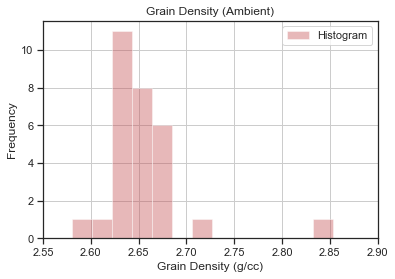

In [18]:
savefn = "Hist_FF_GD.png"

## fuction to plot - usage
## plot_grain_density (dataframe_column, plot_title, number_bins, x-axis_min, x_axis_max savefile_name)
plot_grain_density(df_sub['Grain Density (g/cc)'], "Grain Density (Ambient)", 20, 2.55, 2.9, savefn)

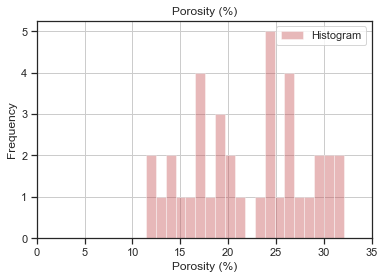

In [19]:
savefn = "Hist_FF_Poro.png"
plot_grain_density(df_sub["Porosity (%)"], "Porosity (%)", 20, 0, 35, savefn)

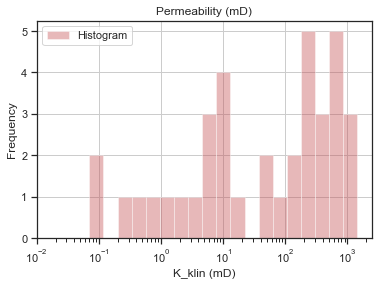

In [20]:
savefn = "Hist_FF_Perm.png"

x= df_sub["K_klin (mD)"]

logbins = np.geomspace(x.min(), x.max(), 20)
plot_grain_density(df_sub["K_klin (mD)"], "Permeability (mD)", logbins, 0.01, x.max()+1000, savefn)
plt.xscale('log')

#### Plot cross-plot of Porosity-Permeability

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\collections.py:1099: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


Equation of line:  
8.938 x - 23.71
Intercept: 8.937547137624566
Gradient Coefficient: -23.71373633818167


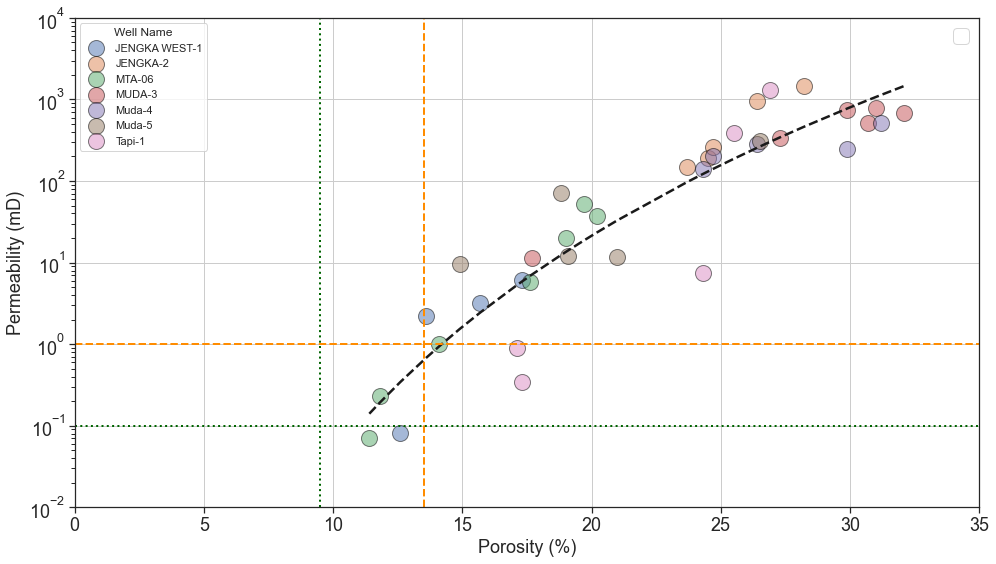

In [21]:
savefn = "Poro_FF_Perm.png"

xlimit = 35
ylimit = 10000

#Cutoff intercept
yint1 = 1
xint1 = 13.5

yint2 = 0.1
xint2 = 9.5

plot_line_eqn = True

f, p0, p1 = plot_PP(df_sub, grouped, color, 
                    "Porosity vs Permeability", savefn, xint1, yint1, 
                    xint2, yint2, xlimit, ylimit, plot_line_eqn)
print("Equation of line:", f)
print("Intercept:", p0)
print("Gradient Coefficient:", p1)

### Evaluation of Formation Factor

In [22]:
df_sub['Porosity_(V/V)'] = df_sub['Porosity (%)']/100

df_sub = df_sub.sort_values("Porosity_(V/V)", ascending=True)

x = df_sub['Porosity_(V/V)']
y = df_sub['F']
m = df_sub['m'].mean()

print('Average Cementation Exponent:', m)

Average Cementation Exponent: 1.7790198869505054


In [23]:
def FF_RI_plot(x, y, a, b1, b2, b3, index_min, 
               index_avg, index_max, savefn, xlim, ylim, xlab, ylab, 
               tit, fs, xcoor, ycoor1, ycoor2, ycoor3
              ):
    # Font, marker size and axis rotation
    edgecolors = 'black'
    markersize = 16
    alpha = 0.5
    size = 18
    rotation = 0
   
    #Plot Raw Data
    plt.figure(figsize=(10,10))
    plt.scatter(x, y, c = 'yellow', edgecolor = edgecolors, s = markersize*10)

    #Fit Min Possible Line
    plt.plot(a, b1, 'r-.', linewidth = 1.5)
    plt.text(xcoor, ycoor1, r'{:.2f}'.format(index_min), fontsize = fs/1.2, bbox=dict(facecolor='white', alpha=0.5))

    #Fit Average Possible Line
    plt.plot(a, b2, 'k-', linewidth = 1.5)
    plt.text(xcoor, ycoor2, r'{:.2f}'.format(index_avg), fontsize = fs/1.2, bbox=dict(facecolor='white', alpha=0.5)) 

    #Fit Max Possible Line
    plt.plot(a, b3, 'b--', linewidth = 1.5)
    plt.text(xcoor, ycoor3, r'{:.2f}'.format(index_max), fontsize = fs/1.2, bbox=dict(facecolor='white', alpha=0.5))
    
    plt.xticks(rotation = rotation, fontsize=fs)
    plt.yticks(rotation = rotation, fontsize=fs)
    plt.xlim(0.01, xlim)
    plt.ylim(0.1, ylim)
    plt.xscale('log')
    plt.yscale('log')

    plt.xlabel(xlab,fontsize=fs)
    plt.ylabel(ylab,fontsize=fs)
    plt.title(tit,fontsize=fs+2)

    plt.savefig(savefn, transparent=True)
    
    plt.show()
    return

In [24]:
x_pts = np.linspace(0.01,1, len(df_sub))

delta_m_min = 0.1
delta_m_max = 0.15

m_avg = m
m_min = m_avg - delta_m_min
m_max = m_avg + delta_m_max

df_new = pd.DataFrame(x_pts, columns = ['Porosity (V/V)'])

df_new['F_avg'] = np.exp(-m_avg*np.log(x_pts))
df_new['F_min'] = np.exp(-m_min*np.log(x_pts))
df_new['F_max'] = np.exp(-m_max*np.log(x_pts))
df_new.ends(5)

C:\Users\mkumar\AppData\Local\Temp\ipykernel_17944\3237448987.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.head(x).append(df.tail(x))


,Porosity (V/V),F_avg,F_min,F_max
0,0.0100,3614.429631,2280.550922,7211.735232
1,0.0375,344.212576,247.873363,563.277032
2,0.0650,129.375114,98.433308,194.945737
3,0.0925,69.064428,54.433792,98.703637
4,0.1200,43.466520,35.161954,59.741715
32,0.8900,1.230371,1.216117,1.252067
33,0.9175,1.165533,1.155540,1.180684
34,0.9450,1.105878,1.099640,1.115302
35,0.9725,1.050859,1.047933,1.055264
36,1.0000,1.000000,1.000000,1.000000


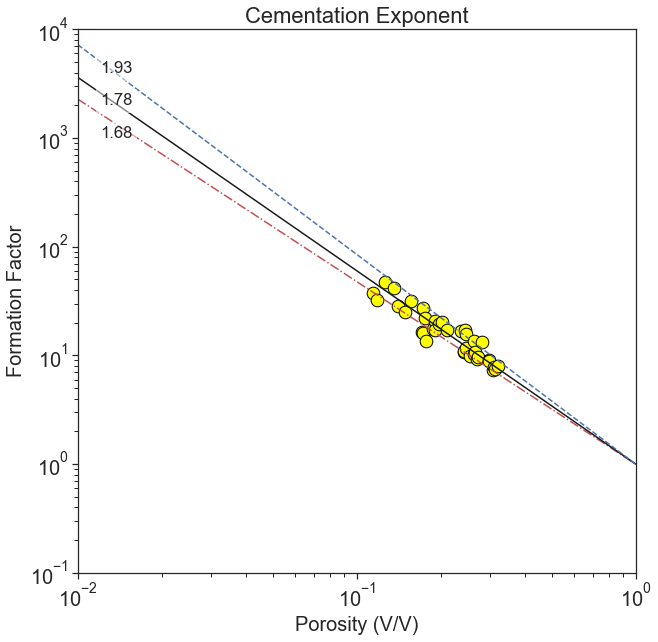

In [25]:
fs=20

a = df_new['Porosity (V/V)']
b1 = df_new['F_min']
b2 = df_new['F_avg']
b3 = df_new['F_max']

index_min = m_min 
index_avg = m_avg 
index_max = m_max

savefn = 'FF.png'
xlim = 1
ylim = 10000
xlab = "Porosity (V/V)"
ylab = "Formation Factor"
tit = "Cementation Exponent"
xcoor = 0.012
ycoor1 = 1000
ycoor2 = 2000
ycoor3 = 4000

FF_RI_plot(x, y, a, b1, b2, b3, index_min, index_avg, 
           index_max, savefn, xlim, ylim, xlab, ylab, tit, fs,
          xcoor, ycoor1, ycoor2, ycoor3)

# Saturation Exponent

##### Read in the data and some preprocessing

In [26]:
# Header file comes preformatted as 1st row is variable name, 2nd row reads "Low, Best, High"
# Combines the first 2 rows of header into 1 header

df = pd.read_excel(
    'CoreData_CPOC.xlsx', 
    header=[0, 1], 
    sheet_name='Elec_Prop_N', 
    keep_default_na=False,
    na_values=['-']
    #usecols="A,C:AA"
)
df.columns=df.columns.to_flat_index()

# renaming the columns
df.columns = ['Well Name', 'Sample ID', 'Depth (m)', 'NOB (psi)', 'K_klin (mD)', 'Porosity (%)','Sw (%)', 'RI', 'n']
df.ends(10)

C:\Users\mkumar\AppData\Local\Temp\ipykernel_17944\3237448987.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.head(x).append(df.tail(x))


,Well Name,Sample ID,Depth (m),NOB (psi),K_klin (mD),Porosity (%),Sw (%),RI,n
0,Muda-4,207,1265.50,800,245.0,29.9,100.000000,1.000000,NaN
1,Muda-4,207,1265.50,800,245.0,29.9,70.943569,1.778476,1.677196
2,Muda-4,207,1265.50,800,245.0,29.9,61.920783,2.255572,1.697015
3,Muda-4,207,1265.50,800,245.0,29.9,51.062854,3.137129,1.701065
4,Muda-4,207,1265.50,800,245.0,29.9,43.569353,4.182398,1.722264
5,Muda-4,207,1265.50,800,245.0,29.9,34.240710,6.480151,1.743630
6,Muda-4,211,1266.07,800,282.0,26.4,100.000000,1.000000,NaN
7,Muda-4,211,1266.07,800,282.0,26.4,82.408042,1.385184,1.684002
8,Muda-4,211,1266.07,800,282.0,26.4,73.497830,1.675187,1.675547
9,Muda-4,211,1266.07,800,282.0,26.4,66.415353,1.975867,1.664071


In [27]:
df = df.replace(r'^\s*$', np.nan, regex=True)

cols = ['K_klin (mD)', 'Porosity (%)', 'Sw (%)', 'RI', 'n']

mod_df = df.dropna(how='any', subset=cols)
mod_df = df[df['K_klin (mD)'] > 0.01]

mod_df['n'] = mod_df['n'].replace(np.nan, 1).astype('float')

mod_df

,Well Name,Sample ID,Depth (m),NOB (psi),K_klin (mD),Porosity (%),Sw (%),RI,n
0,Muda-4,207,1265.50,800,245.000,29.9,100.000000,1.000000,1.000000
1,Muda-4,207,1265.50,800,245.000,29.9,70.943569,1.778476,1.677196
2,Muda-4,207,1265.50,800,245.000,29.9,61.920783,2.255572,1.697015
3,Muda-4,207,1265.50,800,245.000,29.9,51.062854,3.137129,1.701065
4,Muda-4,207,1265.50,800,245.000,29.9,43.569353,4.182398,1.722264
5,Muda-4,207,1265.50,800,245.000,29.9,34.240710,6.480151,1.743630
6,Muda-4,211,1266.07,800,282.000,26.4,100.000000,1.000000,1.000000
7,Muda-4,211,1266.07,800,282.000,26.4,82.408042,1.385184,1.684002
8,Muda-4,211,1266.07,800,282.000,26.4,73.497830,1.675187,1.675547
9,Muda-4,211,1266.07,800,282.000,26.4,66.415353,1.975867,1.664071


In [28]:
print(mod_df.info())
print(mod_df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Well Name     200 non-null    object 
 1   Sample ID     200 non-null    object 
 2   Depth (m)     200 non-null    float64
 3   NOB (psi)     200 non-null    int64  
 4   K_klin (mD)   200 non-null    float64
 5   Porosity (%)  200 non-null    float64
 6   Sw (%)        200 non-null    float64
 7   RI            200 non-null    float64
 8   n             200 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 15.6+ KB
None
       Well Name  Sample ID    Depth (m)    NOB (psi)  K_klin (mD)  \
count        200      200.0   200.000000   200.000000   200.000000   
unique         7       33.0          NaN          NaN          NaN   
top       MTA-06      137.0          NaN          NaN          NaN   
freq          43       11.0          NaN          NaN          NaN   
mean 

### Evaluation of Resistivity Index

In [29]:
mod_df['Sw (V/V)'] = mod_df['Sw (%)']/100

mod_df = mod_df.sort_values('Sw (V/V)', ascending=False)

x1 = mod_df['Sw (V/V)']
y1 = mod_df['RI']
n = mod_df['n'].mean()

print('Average Saturation Exponent:', n)

Average Saturation Exponent: 1.555893559072697


In [30]:
x_pts1 = np.linspace(0.01,1, len(mod_df))

delta_n_min = 0.25
delta_n_max = 0.25

n_avg = n + 0.3
n_min = n_avg - delta_n_min
n_max = n_avg + delta_n_max

df_new = pd.DataFrame(x_pts1, columns = ['Sw (V/V)'])

df_new['RI_avg'] = x_pts1**(-n_avg)
df_new['RI_min'] = x_pts1**(-n_min)
df_new['RI_max'] = x_pts1**(-n_max)
df_new.ends(5)

C:\Users\mkumar\AppData\Local\Temp\ipykernel_17944\3237448987.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.head(x).append(df.tail(x))


,Sw (V/V),RI_avg,RI_min,RI_max
0,0.010000,5149.761524,1628.497582,16284.975823
1,0.014975,2434.062400,851.476183,6958.103921
2,0.019950,1429.338767,537.179624,3803.214459
3,0.024925,945.554692,375.702257,2379.739964
4,0.029899,674.536678,280.492686,1622.144720
195,0.980101,1.038008,1.032805,1.043237
196,0.985075,1.028300,1.024442,1.032173
197,0.990050,1.018731,1.016188,1.021281
198,0.995025,1.009299,1.008041,1.010558
199,1.000000,1.000000,1.000000,1.000000


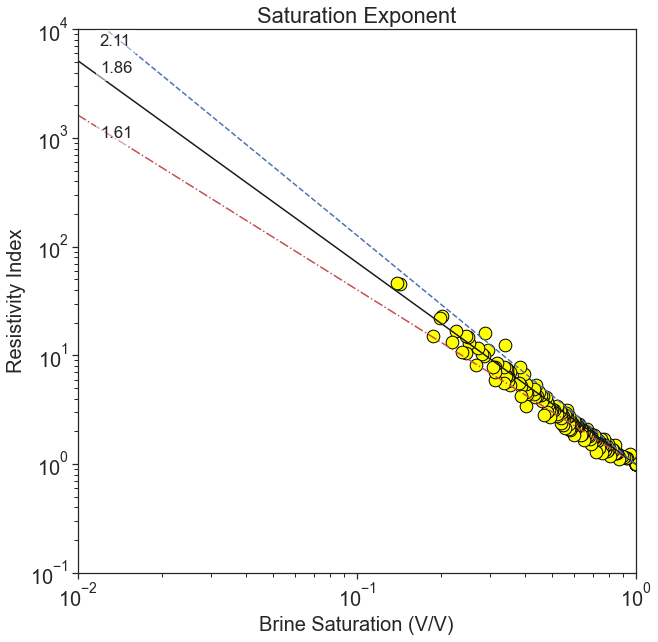

In [31]:
a = df_new['Sw (V/V)']
b1 = df_new['RI_min']
b2 = df_new['RI_avg']
b3 = df_new['RI_max']

index_min = n_min 
index_avg = n_avg 
index_max = n_max

savefn = 'RI.png'
xlim = 1
ylim = 10000
xlab = "Brine Saturation (V/V)"
ylab = "Resistivity Index"
tit = "Saturation Exponent"
xcoor = 0.012
ycoor1 = 1000
ycoor2 = 4000
ycoor3 = 7000

FF_RI_plot(x1, y1, a, b1, b2, b3, index_min, index_avg, 
           index_max, savefn, xlim, ylim, xlab, ylab, tit, fs,
          xcoor, ycoor1, ycoor2, ycoor3)

-------------------------

-------------------------

# Clay Corrected values

##### Read in the data and some preprocessing

In [32]:
# Header file comes preformatted as 1st row is variable name, 2nd row reads "Low, Best, High"
# Combines the first 2 rows of header into 1 header

df = pd.read_excel(
    'CoreData_CPOC.xlsx', 
    header=[0, 1], 
    sheet_name='Elec_Prop_M_Star', 
    keep_default_na=False,
    na_values=['-']
    #usecols="A,C:AA"
)
df.columns=df.columns.to_flat_index()

# renaming the columns
df.columns = ['Well Name', 'Sample ID', 'Depth (m)', 'NOB (psi)', 'Grain Density (g/cc)', 'K_klin (mD)', 'Porosity (%)', 'F_star', 'm_star']
df.ends(10)

C:\Users\mkumar\AppData\Local\Temp\ipykernel_17944\3237448987.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.head(x).append(df.tail(x))


,Well Name,Sample ID,Depth (m),NOB (psi),Grain Density (g/cc),K_klin (mD),Porosity (%),F_star,m_star
0,MUDA-3,131,1275.05,800,2.71,794.000,31.0,8.439793,1.821199
1,MUDA-3,137,1276.90,800,2.63,740.000,29.9,9.246186,1.842284
2,MUDA-3,147,1279.90,800,3.00,675.000,32.1,8.364638,1.869213
3,MUDA-3,153,1281.70,800,2.85,513.000,30.7,9.452805,1.902191
4,MUDA-3,159,1283.50,800,2.63,11.400,17.7,27.911212,1.922510
5,TAPI-1,S1A,1848.46,800,2.62,0.348,17.3,18.000000,1.650000
6,TAPI-1,S2B,1855.82,800,2.63,7.560,24.3,13.000000,1.810000
7,TAPI-1,S3A,1856.96,800,2.65,1310.000,26.9,9.700000,1.730000
8,TAPI-1,S4A,1858.07,800,2.64,385.000,25.5,10.000000,1.690000
9,TAPI-1,S5B,1863.26,800,2.65,0.910,17.1,24.300000,1.810000


#### Clay Corrected Cementation Exponent

In [33]:
df['Porosity_(V/V)'] = df['Porosity (%)']/100

df = df.sort_values("Porosity_(V/V)", ascending=True)

x_star = df['Porosity_(V/V)']
y_star = df['F_star']
m_star = df['m_star'].mean()

print('Average Clay Corrected Cementation Exponent:', m_star)

Average Clay Corrected Cementation Exponent: 1.8047396979220902


In [34]:
x_pts_star = np.linspace(0.01,1, len(df))

delta_m_min_star = 0.1
delta_m_max_star = 0.15

m_avg_star = m_star
m_min_star = m_avg_star - delta_m_min_star
m_max_star = m_avg_star + delta_m_max_star

df_new_m_star = pd.DataFrame(x_pts_star, columns = ['Porosity (V/V)'])

df_new_m_star['F_avg'] = np.exp(-m_avg_star*np.log(x_pts_star))
df_new_m_star['F_min'] = np.exp(-m_min_star*np.log(x_pts_star))
df_new_m_star['F_max'] = np.exp(-m_max_star*np.log(x_pts_star))
df_new_m_star.ends(5)

C:\Users\mkumar\AppData\Local\Temp\ipykernel_17944\3237448987.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.head(x).append(df.tail(x))


,Porosity (V/V),F_avg,F_min,F_max
0,0.01,4068.922292,2567.316404,8118.567312
1,0.12,45.902692,37.132679,63.090065
2,0.23,14.187802,12.248641,17.687072
3,0.34,7.007427,6.290809,8.238284
4,0.45,4.225335,3.901058,4.762986
5,0.56,2.847443,2.687038,3.106182
6,0.67,2.060107,1.979234,2.187653
7,0.78,1.565818,1.527392,1.625275
8,0.89,1.234065,1.219767,1.255826
9,1.00,1.000000,1.000000,1.000000


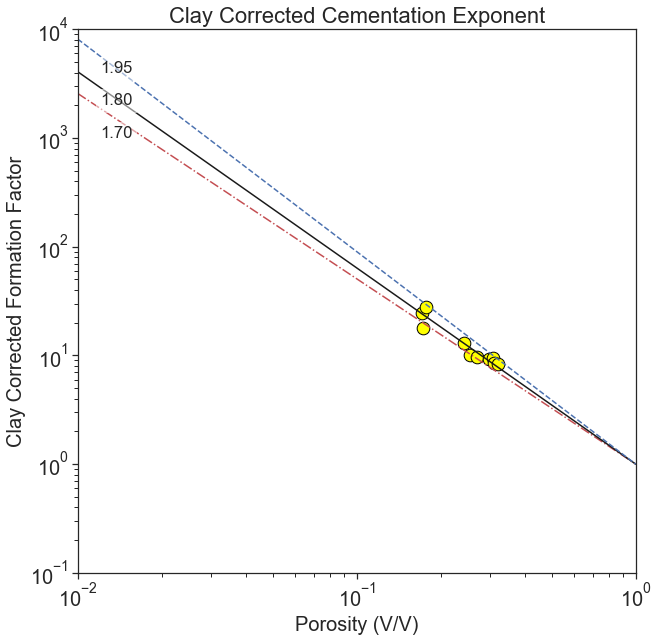

In [35]:
a = df_new_m_star['Porosity (V/V)']
b1 = df_new_m_star['F_min']
b2 = df_new_m_star['F_avg']
b3 = df_new_m_star['F_max']

index_min = m_min_star 
index_avg = m_avg_star 
index_max = m_max_star

savefn = 'FF_star.png'
xlim = 1
ylim = 10000
xlab = "Porosity (V/V)"
ylab = "Clay Corrected Formation Factor"
tit = "Clay Corrected Cementation Exponent"
xcoor = 0.012
ycoor1 = 1000
ycoor2 = 2000
ycoor3 = 4000

FF_RI_plot(x_star, y_star, a, b1, b2, b3, index_min, index_avg, 
           index_max, savefn, xlim, ylim, xlab, ylab, tit, fs,
          xcoor, ycoor1, ycoor2, ycoor3)

#### Clay Corrected Saturation Exponent

In [36]:
# Header file comes preformatted as 1st row is variable name, 2nd row reads "Low, Best, High"
# Combines the first 2 rows of header into 1 header

df = pd.read_excel(
    'CoreData_CPOC.xlsx', 
    header=[0, 1], 
    sheet_name='Elec_Prop_N_Star', 
    keep_default_na=False,
    na_values=['-']
    #usecols="A,C:AA"
)
df.columns=df.columns.to_flat_index()

# renaming the columns
df.columns = ['Well Name', 'Sample ID', 'Depth (m)', 'NOB (psi)', 'K_klin (mD)', 'Porosity (%)','Sw (%)', 'RI_star', 'n_star']
df.ends(10)

C:\Users\mkumar\AppData\Local\Temp\ipykernel_17944\3237448987.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.head(x).append(df.tail(x))


,Well Name,Sample ID,Depth (m),NOB (psi),K_klin (mD),Porosity (%),Sw (%),RI_star,n_star
0,Muda-3,131,1275.05,800,794.0,31.0,100.000000,1.000000,NaN
1,Muda-3,131,1275.05,800,794.0,31.0,61.350141,2.376675,1.771901
2,Muda-3,131,1275.05,800,794.0,31.0,48.588395,3.736404,1.826199
3,Muda-3,131,1275.05,800,794.0,31.0,38.951974,5.841879,1.872058
4,Muda-3,131,1275.05,800,794.0,31.0,31.242838,8.918065,1.880795
5,Muda-3,137,1276.90,800,740.0,29.9,100.000000,1.000000,NaN
6,Muda-3,137,1276.90,800,740.0,29.9,64.181911,2.129508,1.704574
7,Muda-3,137,1276.90,800,740.0,29.9,57.941528,2.586698,1.741469
8,Muda-3,137,1276.90,800,740.0,29.9,45.973671,3.878344,1.744185
9,Muda-3,137,1276.90,800,740.0,29.9,34.860660,6.796630,1.818568


In [37]:
df = df.replace(r'^\s*$', np.nan, regex=True)

cols = ['K_klin (mD)', 'Porosity (%)', 'Sw (%)', 'RI_star', 'n_star']

mod_df = df.dropna(how='any', subset=cols)
mod_df = df[df['K_klin (mD)'] > 0.01]

mod_df['n_star'] = mod_df['n_star'].replace(np.nan, 1).astype('float')

mod_df

,Well Name,Sample ID,Depth (m),NOB (psi),K_klin (mD),Porosity (%),Sw (%),RI_star,n_star
0,Muda-3,131,1275.05,800,794.0,31.0,100.000000,1.000000,1.000000
1,Muda-3,131,1275.05,800,794.0,31.0,61.350141,2.376675,1.771901
2,Muda-3,131,1275.05,800,794.0,31.0,48.588395,3.736404,1.826199
3,Muda-3,131,1275.05,800,794.0,31.0,38.951974,5.841879,1.872058
4,Muda-3,131,1275.05,800,794.0,31.0,31.242838,8.918065,1.880795
5,Muda-3,137,1276.90,800,740.0,29.9,100.000000,1.000000,1.000000
6,Muda-3,137,1276.90,800,740.0,29.9,64.181911,2.129508,1.704574
7,Muda-3,137,1276.90,800,740.0,29.9,57.941528,2.586698,1.741469
8,Muda-3,137,1276.90,800,740.0,29.9,45.973671,3.878344,1.744185
9,Muda-3,137,1276.90,800,740.0,29.9,34.860660,6.796630,1.818568


In [38]:
mod_df['Sw (V/V)'] = mod_df['Sw (%)']/100

mod_df = mod_df.sort_values('Sw (V/V)', ascending=False)

x1_star = mod_df['Sw (V/V)']
y1_star = mod_df['RI_star']
n_star = mod_df['n_star'].mean()

print('Average Clay Corrected Saturation Exponent:', n_star)

Average Clay Corrected Saturation Exponent: 1.6107331227270953


In [39]:
x_pts1_star = np.linspace(0.01,1, len(mod_df))

delta_n_min_star = 0.2
delta_n_max_star = 0.1

n_avg_star = n_star + 0.3
n_min_star = n_avg_star - delta_n_min_star
n_max_star = n_avg_star + delta_n_max_star

df_n_star = pd.DataFrame(x_pts1_star, columns = ['Sw (V/V)'])

df_n_star['RI_avg'] = x_pts1_star**(-n_avg_star)
df_n_star['RI_min'] = x_pts1_star**(-n_min_star)
df_n_star['RI_max'] = x_pts1_star**(-n_max_star)
df_n_star.ends(5)

C:\Users\mkumar\AppData\Local\Temp\ipykernel_17944\3237448987.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.head(x).append(df.tail(x))


,Sw (V/V),RI_avg,RI_min,RI_max
0,0.01000,6629.278211,2639.163191,10506.697908
1,0.05125,292.032147,161.201632,393.062195
2,0.09250,94.499005,58.702363,119.898310
3,0.13375,46.711025,31.237635,57.120239
4,0.17500,27.948099,19.722405,33.269668
20,0.83500,1.411355,1.361362,1.437036
21,0.87625,1.287130,1.253569,1.304247
22,0.91750,1.178826,1.158700,1.189020
23,0.95875,1.083817,1.074725,1.088393
24,1.00000,1.000000,1.000000,1.000000


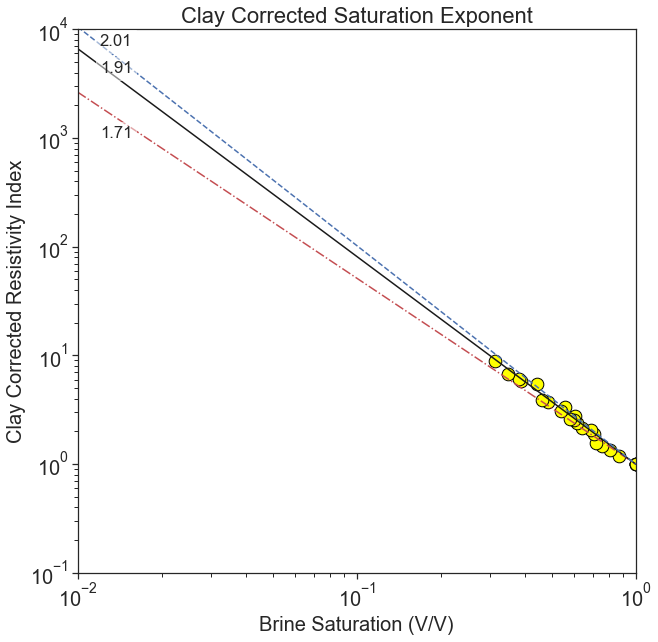

In [40]:
a = df_n_star['Sw (V/V)']
b1 = df_n_star['RI_min']
b2 = df_n_star['RI_avg']
b3 = df_n_star['RI_max']

index_min = n_min_star
index_avg = n_avg_star 
index_max = n_max_star

savefn = 'RI_star.png'
xlim = 1
ylim = 10000
xlab = "Brine Saturation (V/V)"
ylab = "Clay Corrected Resistivity Index"
tit = "Clay Corrected Saturation Exponent"
xcoor = 0.012
ycoor1 = 1000
ycoor2 = 4000
ycoor3 = 7000

FF_RI_plot(x1_star, y1_star, a, b1, b2, b3, index_min, index_avg, 
           index_max, savefn, xlim, ylim, xlab, ylab, tit, fs,
          xcoor, ycoor1, ycoor2, ycoor3)

In [41]:
count = 'Completed Process'
elapsed = (time.time() - start)
print ("%s in %s seconds" % (count,elapsed))

Completed Process in 6.614233493804932 seconds
